In [1]:
!pip install tabulate

In [2]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

In [3]:
from torch.utils.data import DataLoader

In [4]:
from sklearn.metrics import f1_score, precision_score, accuracy_score, recall_score, roc_auc_score

In [5]:
from tabulate import tabulate

In [6]:
!pip install transformers

In [7]:
from transformers import AutoTokenizer, AutoModel

# Initialize the tokenizer and model for Tiny-RoBERTa


/home/yash/miniconda3/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [8]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [9]:
class TextDataset():
    def __init__(self, texts, labels, tokeniser, max_len):
        self.texts = texts
        self.labels = labels
        self.tokeniser = tokeniser
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        encoding = self.tokeniser(text, truncation = True, max_length = self.max_len, return_tensors = 'pt', padding='max_length')

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'label': torch.tensor(label, dtype = torch.long)
        }

In [ ]:
class RCNN_Tiny_RoBERTa(nn.Module):
    def __init__(self, lstm_units, lstm_dropout, lstm_hidden, kernel_size, num_labels):
        super(RCNN_Tiny_RoBERTa, self).__init__()
        self.tiny_roberta = AutoModel.from_pretrained("deepset/tinyroberta-squad2")
        self.hidden_dim = self.tiny_roberta.config.hidden_size
        self.lstm = nn.LSTM(input_size = self.hidden_dim, hidden_size = lstm_hidden, num_layers = lstm_units, dropout = lstm_dropout, bidirectional = True)

        self.lstm_out_dim = lstm_hidden * 2

        self.conv1d = nn.Conv1d(in_channels = self.hidden_dim + self.lstm_out_dim, out_channels = 128, kernel_size = kernel_size, padding = kernel_size // 2)

        self.max_pool = nn.MaxPool1d(kernel_size = 2)

        self.linear = nn.Linear(128, num_labels)

    def forward(self, input_ids, attention):
        roberta_out = self.tiny_roberta(input_ids = input_ids, attention_mask = attention)

        roberta_last_hidden = roberta_out.last_hidden_state

        lstm_out, _ = self.lstm(roberta_last_hidden)

        concatenated_out = torch.cat((roberta_last_hidden, lstm_out), dim = 2)

        conv_in = concatenated_out.permute(0, 2, 1)

        conv_out = self.conv1d(conv_in)

        pooled_out = self.max_pool(conv_out)

        max_pooled = torch.max(pooled_out, dim = 2).values

        logits = self.linear(max_pooled)

        return logits

In [ ]:
from huggingface_hub import login

The token has not been saved to the git credentials helper. Pass `add_to_git_credential=True` in this function directly or `--add-to-git-credential` if using via `huggingface-cli` if you want to set the git credential as well.
Token is valid (permission: write).
Your token has been saved to /home/yash/.cache/huggingface/token
Login successful


In [ ]:
tokenizer = AutoTokenizer.from_pretrained("deepset/tinyroberta-squad2")

/home/yash/miniconda3/lib/python3.12/site-packages/transformers/models/auto/tokenization_auto.py:786: FutureWarning: The `use_auth_token` argument is deprecated and will be removed in v5 of Transformers. Please use `token` instead.
  warnings.warn(
/home/yash/miniconda3/lib/python3.12/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [13]:
def compute_metrics(predictions, targets, softmax_out):
  '''
    A function to compute the classification metrics
  '''
  prec = precision_score(targets, predictions, average = 'binary')
  acc = accuracy_score(targets, predictions)
  f1 = f1_score(targets, predictions, average = 'binary')
  recall = recall_score(targets, predictions, average = 'binary')
  auc = roc_auc_score(targets, softmax_out, average = 'macro')

  return prec, acc, f1, recall, auc

In [14]:
def train_epoch(model, dataloader, opt, loss_fn, device):
    total_loss = 0

    predictions = []
    targets = []
    softmax_val = []
    for data in dataloader:
        opt.zero_grad()

        input_ids = data['input_ids'].to(device)
        attention_mask = data['attention_mask'].to(device)
        target = data['label'].to(device)

        output = model(input_ids, attention_mask)

        loss = loss_fn(output, target)

        soft_out = F.softmax(output, dim = 1)
        prediction = torch.argmax(soft_out, dim = 1)
        softmax_val.extend(soft_out[:,1].cpu().detach().numpy())
        predictions.extend(prediction.cpu())
        targets.extend(target.cpu())

        loss.backward()
        opt.step()

        total_loss += loss.item()

    prec, acc, f1, recall, auc = compute_metrics(predictions, targets, softmax_val)
    avg_loss = total_loss / len(dataloader)
    return avg_loss, prec, acc, f1, recall, auc

In [15]:
def train_model(model, train_set, epochs, lr, eps, weight_decay, device):
    opt = optim.Adam(model.parameters(), lr = lr, eps = eps, weight_decay = weight_decay)

    loss_fn = nn.CrossEntropyLoss()

    train_loss = []
    train_acc = []
    train_prec = []
    train_f1 = []
    train_recall = []
    train_auc = []

    for epoch in range(1, epochs + 1):
        loss_epoch, prec_epoch, acc_epoch, f1_epoch, recall_epoch, auc_epoch = train_epoch(model, train_set, opt, loss_fn, device)
        train_loss.append(loss_epoch)
        train_acc.append(acc_epoch)
        train_f1.append(f1_epoch)
        train_recall.append(recall_epoch)
        train_prec.append(prec_epoch)
        train_auc.append(auc_epoch)
        metrics = tabulate([[epoch, loss_epoch, prec_epoch, acc_epoch, f1_epoch, recall_epoch, auc_epoch]], headers = ['Epoch', 'Train Loss', 'Train Precision', 'Train Accuracy', 'Train f1', 'Train Recall', 'Train AUC'], tablefmt = 'grid')
        print(metrics)
    return train_loss, train_acc, train_prec, train_f1, train_recall, train_auc

In [ ]:
df = pd.read_csv('train_unb.csv')
texts = df['text'].tolist()
labels = df['label'].tolist()
tokeniser = AutoTokenizer.from_pretrained("deepset/tinyroberta-squad2")
dataset = TextDataset(texts, labels, tokeniser, 30)

dataloader = DataLoader(dataset, batch_size = 128)

/home/yash/miniconda3/lib/python3.12/site-packages/transformers/models/auto/tokenization_auto.py:786: FutureWarning: The `use_auth_token` argument is deprecated and will be removed in v5 of Transformers. Please use `token` instead.
  warnings.warn(
/home/yash/miniconda3/lib/python3.12/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [17]:
lstm_units = 64
lstm_dropout = 0.1
eps = 1e-6
epochs = 5
lr = 2e-5
weight_decay = 1e-5
lstm_hidden = 128
kernel_sz = 3
num_labels = 2
model = RCNN_Tiny_RoBERTa(lstm_units = 64, lstm_dropout = lstm_dropout, kernel_size= kernel_sz, num_labels = num_labels, lstm_hidden = lstm_hidden).to(device)

/home/yash/miniconda3/lib/python3.12/site-packages/transformers/models/auto/auto_factory.py:469: FutureWarning: The `use_auth_token` argument is deprecated and will be removed in v5 of Transformers. Please use `token` instead.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at deepset/tinyroberta-squad2 and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
loss, accuracy, precision, f1, recall, auc = train_model(model, dataloader, epochs, lr, eps, weight_decay, device)

In [ ]:
def test_model(model, dataloader, loss_fn, device):
    total_loss = 0

    predictions = []
    targets = []
    softmax_val = []
    for data in dataloader:
        input_ids = data['input_ids'].to(device)
        attention_mask = data['attention_mask'].to(device)
        target = data['label'].to(device)

        output = model(input_ids, attention_mask)
        loss = loss_fn(output, target)

        soft_out = F.softmax(output, dim = 1)
        prediction = torch.argmax(soft_out, dim = 1)
        softmax_val.extend(soft_out[:,1].cpu().detach().numpy())
        predictions.extend(prediction.cpu())
        targets.extend(target.cpu())

        total_loss += loss.item()

    prec, acc, f1, recall, auc = compute_metrics(predictions, targets, softmax_val)
    avg_loss = total_loss / len(dataloader)
    return avg_loss, prec, acc, f1, recall, auc

In [ ]:
df = pd.read_csv('test_unb.csv')
texts = df['text'].tolist()
labels = df['label'].tolist()

dataset = TextDataset(texts, labels, tokeniser, 30)

dataloader = DataLoader(dataset, batch_size = 128)

In [ ]:
lo = nn.CrossEntropyLoss()
_loss,_precision,_accuracy,_f1,_recall,_auc = test_model(model,dataloader,lo,device)

In [ ]:
print("Loss: ",_loss,"\nPrecision: ",_precision,"\nAccuracy: ",_accuracy,"\nF1: ",_f1, "\nRecall: ",_recall, "\nAUC: ",_auc)

Loss:  0.3998341735866335 
Precision:  0.8958976621085134 
Accuracy:  0.880083784255542 
F1:  0.8553379658875553 
Recall:  0.8182917002417406 
AUC:  0.9480573030035535


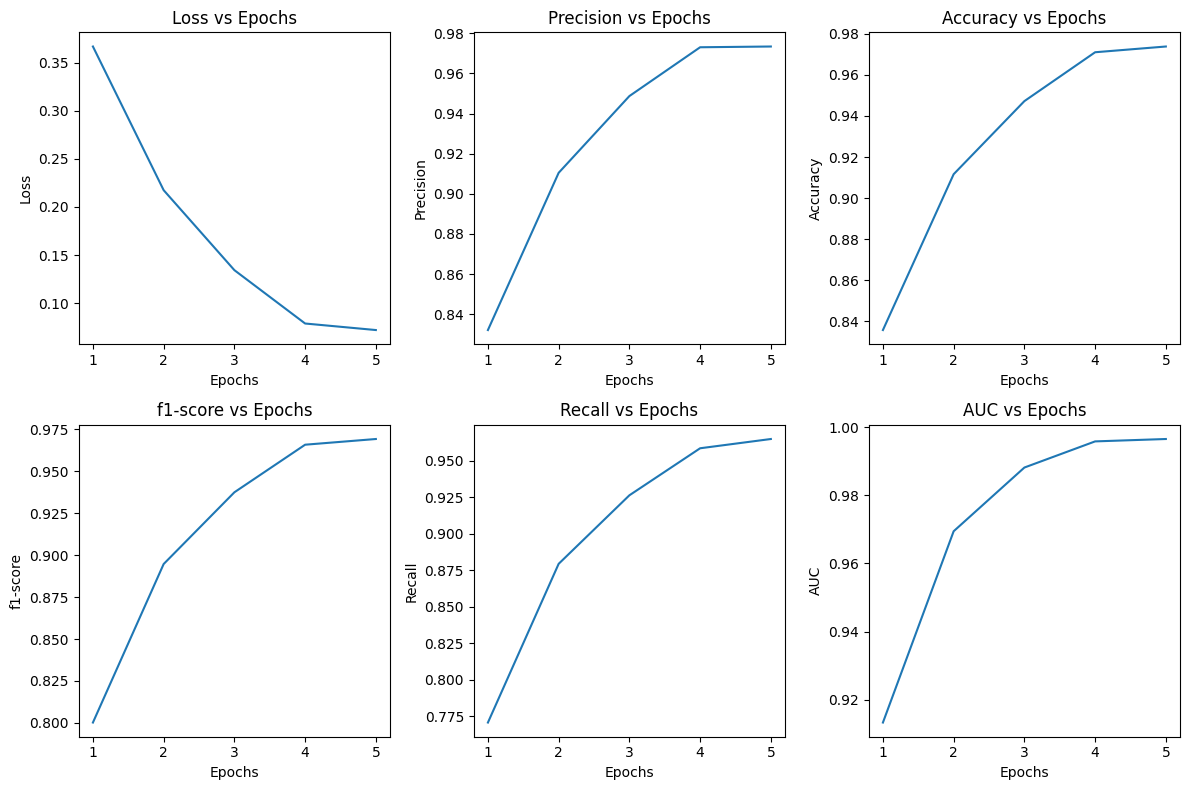

In [ ]:
import matplotlib.pyplot as plt
fig, axs = plt.subplots(2, 3, figsize=(12, 8))
x = np.arange(1, epochs + 1)
axs[0, 0].plot(x, loss)
axs[0, 0].set_xlabel('Epochs')
axs[0, 0].set_ylabel('Loss')
axs[0, 0].set_title('Loss vs Epochs')

# Second subplot (top middle)
axs[0, 1].plot(x, precision)
axs[0, 1].set_xlabel('Epochs')
axs[0, 1].set_ylabel('Precision')
axs[0, 1].set_title('Precision vs Epochs')

# Third subplot (top right)
axs[0, 2].plot(x, accuracy)
axs[0, 2].set_xlabel('Epochs')
axs[0, 2].set_ylabel('Accuracy')
axs[0, 2].set_title('Accuracy vs Epochs')

# Fourth subplot (bottom left)
axs[1, 0].plot(x, f1)
axs[1, 0].set_xlabel('Epochs')
axs[1, 0].set_ylabel('f1-score')
axs[1, 0].set_title('f1-score vs Epochs')

# Fifth subplot (bottom middle)
axs[1, 1].plot(x, recall)
axs[1, 1].set_xlabel('Epochs')
axs[1, 1].set_ylabel('Recall')
axs[1, 1].set_title('Recall vs Epochs')

# Sixth subplot (bottom right)
axs[1, 2].plot(x, auc)
axs[1, 2].set_xlabel('Epochs')
axs[1, 2].set_ylabel('AUC')
axs[1, 2].set_title('AUC vs Epochs')

# Adjust layout to prevent overlapping
plt.tight_layout()

In [ ]:
save_directory = "./Modified_RCNN_Tiny_RoBERTa"
torch.save(model.state_dict(), f"{save_directory}/model_state_dict.pt")


In [ ]:
tokenizer.save_pretrained(save_directory)

('./Modified_RCNN_Tiny_RoBERTa/tokenizer_config.json',
 './Modified_RCNN_Tiny_RoBERTa/special_tokens_map.json',
 './Modified_RCNN_Tiny_RoBERTa/vocab.json',
 './Modified_RCNN_Tiny_RoBERTa/merges.txt',
 './Modified_RCNN_Tiny_RoBERTa/added_tokens.json',
 './Modified_RCNN_Tiny_RoBERTa/tokenizer.json')

In [ ]:
!zip -r trained_rcnn_tiny_roberta.zip ./Modified_RCNN_Tiny_RoBERTa



  adding: Modified_RCNN_Tiny_RoBERTa/ (stored 0%)
  adding: Modified_RCNN_Tiny_RoBERTa/model_state_dict.pt (deflated 7%)
  adding: Modified_RCNN_Tiny_RoBERTa/merges.txt (deflated 53%)
  adding: Modified_RCNN_Tiny_RoBERTa/tokenizer.json (deflated 82%)
  adding: Modified_RCNN_Tiny_RoBERTa/special_tokens_map.json (deflated 85%)
  adding: Modified_RCNN_Tiny_RoBERTa/vocab.json (deflated 59%)
  adding: Modified_RCNN_Tiny_RoBERTa/tokenizer_config.json (deflated 76%)


In [ ]:
from google.colab import files
files.download('trained_rcnn_tiny_roberta.zip')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>